# Project Setup

In [1]:
! git clone https://github.com/pratyushsharma258/Block-Query.git
! cd Block-Query && pip install -r requirements_Pegasus.txt

Cloning into 'Block-Query'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 99 (delta 37), reused 76 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (99/99), 2.18 MiB | 4.83 MiB/s, done.
Resolving deltas: 100% (37/37), done.
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=e7baf4500a7e152dd9ca7708d0ccb16719a05a84319bed5ba79e5ffb982d41a1
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [2]:
import os
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import PegasusConfig, TFPegasusForConditionalGeneration, PegasusTokenizer, GenerationConfig
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
import nltk
import random
import re

nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
SAVE_DIR = "/content/drive/MyDrive/block-query/Pegasus"
os.makedirs(SAVE_DIR, exist_ok=True)
CHECKPOINT_MODEL_PATH = os.path.join(SAVE_DIR, "checkpoint_model.keras")
FULL_MODEL_PATH = os.path.join(SAVE_DIR, "full_model.keras")

# Final Tuned Pegasus


In [6]:
MAX_SOURCE_LENGTH = 50
MAX_TARGET_LENGTH = 200
BATCH_SIZE = 2
TOTAL_EPOCHS = 8
EPOCHS_PER_STEP = 2
LEARNING_RATE = 1e-4
DATA_PATH = "./Block-Query/dataset"
MODEL_SIZE = "google/pegasus-xsum"

## Data Preprocessing

In [7]:
def get_synonyms(word):
    try:
        synonyms = []
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.name() != word and '_' not in lemma.name():
                    synonyms.append(lemma.name())
        return list(set(synonyms))
    except LookupError:
        nltk.download('wordnet')
        return get_synonyms(word)
    except Exception as e:
        print(f"Synonym error: {str(e)}")
        return []

def selective_augment_data(question, answer, augmentation_factor=3):
    augmented_pairs = [(question, answer)]

    if len(question.split()) < 6:
        prefixes = [
            "Can you tell me ", "I want to know ", "Please explain ",
            "What is ", "Could you describe ", "Help me understand ",
            "I'm curious about ", "Define "
        ]

        added = 0
        for prefix in prefixes:
            if added >= augmentation_factor:
                break

            # Add prefix if it makes sense
            if not question.lower().startswith(prefix.lower()):
                new_q = prefix + question.lower()
                augmented_pairs.append((new_q, answer))
                added += 1
    else:
        words = question.split()

        if len(words) >= 5:
            replaced_words = 0
            max_replacements = min(3, augmentation_factor)

            for i in range(len(words)):
                if replaced_words >= max_replacements:
                    break

                if len(words[i]) <= 3 or words[i].lower() in ["the", "and", "or", "a", "an", "of", "to", "in", "is", "are"]:
                    continue

                synonyms = get_synonyms(words[i])
                if synonyms:
                    new_words = words.copy()
                    new_words[i] = random.choice(synonyms)
                    new_q = ' '.join(new_words)
                    augmented_pairs.append((new_q, answer))
                    replaced_words += 1

    blockchain_terms = {
        "blockchain": ["distributed ledger", "chain of blocks", "block chain"],
        "bitcoin": ["btc", "bitcoin cryptocurrency", "digital gold"],
        "ethereum": ["eth", "ether platform", "ethereum platform"],
        "smart contract": ["self-executing contract", "automated contract", "blockchain contract"],
        "defi": ["decentralized finance", "open finance", "defi protocols"],
        "nft": ["non-fungible token", "digital collectible", "crypto collectible"],
        "mining": ["cryptocurrency mining", "block mining", "crypto mining"],
        "wallet": ["crypto wallet", "digital wallet", "blockchain wallet"],
        "token": ["cryptocurrency token", "digital token", "crypto token"],
        "consensus": ["agreement mechanism", "consensus protocol", "blockchain consensus"],
        "proof of stake": ["pos", "staking mechanism", "staking protocol"],
        "proof of work": ["pow", "mining consensus", "work-based consensus"]
    }

    for term, variants in blockchain_terms.items():
        if term in question.lower():
            for variant in variants:
                if len(augmented_pairs) < augmentation_factor + 1:
                    new_q = question.lower().replace(term, variant)
                    augmented_pairs.append((new_q, answer))

    if question.lower().startswith("what is"):
        reformulations = [
            question.lower().replace("what is", "could you explain"),
            question.lower().replace("what is", "describe"),
            "give me information about" + question.lower().replace("what is", "")
        ]
        for reform in reformulations:
            if len(augmented_pairs) < augmentation_factor + 1:
                augmented_pairs.append((reform, answer))

    if question.lower().startswith("how does"):
        reformulations = [
            question.lower().replace("how does", "explain how"),
            question.lower().replace("how does", "describe the functioning of"),
            "what is the mechanism behind" + question.lower().replace("how does", "")
        ]
        for reform in reformulations:
            if len(augmented_pairs) < augmentation_factor + 1:
                augmented_pairs.append((reform, answer))

    return augmented_pairs[:augmentation_factor + 1]

def load_data(dataset_path):
    data = []
    for file in sorted(os.listdir(dataset_path)):
        if file.endswith(".json"):
            with open(os.path.join(dataset_path, file), "r", encoding="utf-8") as f:
                content = json.load(f)
                qa_pairs = content.get("qa_pairs", [])
                for pair in qa_pairs:
                    data.append({"question": pair["question"], "answer": pair["answer"]})
    return pd.DataFrame(data)

def improved_clean_text(text):
    text = text.lower().strip()
    # Preserve more meaningful punctuation and symbols
    text = re.sub(r'[^\w\s.,!?\'"-:;$%#@&*()]', ' ', text)
    # Normalize numbers
    text = re.sub(r'\d+', 'NUM', text)
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text)
    return f"<START> {text} <END>"

def preprocess_data_pegasus(df, tokenizer, max_source_length=128, max_target_length=256):
    questions = df["question"].apply(lambda x: x.lower().strip()).tolist()
    answers = df["answer"].apply(lambda x: x.lower().strip()).tolist()

    question_encodings = tokenizer(
        questions,
        padding="max_length",
        truncation=True,
        max_length=max_source_length,
        return_tensors="tf"
    )

    answer_encodings = tokenizer(
        answers,
        padding="max_length",
        truncation=True,
        max_length=max_target_length,
        return_tensors="tf"
    )

    # Set up labels
    labels = answer_encodings.input_ids
    # Replace pad token id with -100 for loss calculation
    labels = tf.where(labels == tokenizer.pad_token_id, -100, labels)

    inputs = {
        "input_ids": question_encodings.input_ids,
        "attention_mask": question_encodings.attention_mask
    }

    return inputs, labels

def prepare_data_for_pegasus(df_data, validation_split=0.2, test_split=0.1, apply_augmentation=True):
    df = df_data.copy()

    # Clean the text
    df["question"] = df["question"].apply(lambda x: x.lower().strip())
    df["answer"] = df["answer"].apply(lambda x: x.lower().strip())

    # Remove any special tokens that might exist in the data
    df["question"] = df["question"].apply(lambda x: x.replace("<START>", "").replace("<END>", "").strip())
    df["answer"] = df["answer"].apply(lambda x: x.replace("<START>", "").replace("<END>", "").strip())

    # Apply selective augmentation
    if apply_augmentation:
        print("Applying selective augmentation...")
        augmented_data = []
        for _, row in df.iterrows():
            pairs = selective_augment_data(row['question'], row['answer'], augmentation_factor=3)
            augmented_data.extend(pairs)

        df_augmented = pd.DataFrame(augmented_data, columns=['question', 'answer'])
        print(f"Data size after augmentation: {len(df_augmented)} (from original {len(df)})")

        df_augmented.to_csv(os.path.join(DATA_PATH, "df_augmented.csv"), index=False)
        print(f"Augmented dataset saved to {os.path.join(DATA_PATH, 'df_augmented.csv')}")
    else:
        df_augmented = df
        print("Skipping augmentation")

    # Split the data
    df_shuffled = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)

    # Calculate split indices
    val_idx = int(len(df_shuffled) * (1 - validation_split - test_split))
    test_idx = int(len(df_shuffled) * (1 - test_split))

    # Create splits
    df_train = df_shuffled.iloc[:val_idx]
    df_val = df_shuffled.iloc[val_idx:test_idx]
    df_test = df_shuffled.iloc[test_idx:]

    print(f"Train set: {len(df_train)} samples")
    print(f"Validation set: {len(df_val)} samples")
    print(f"Test set: {len(df_test)} samples")

    return df_train, df_val, df_test

## Dataset Analysis

Loading original dataset...
Original dataset loaded: 1737 QA pairs

ORIGINAL DATASET - Dataset Analysis
Total number of samples: 1737

Question Length Statistics:
Mean: 11.53 words
Median: 11.0 words
Min: 3 words
Max: 40 words

Answer Length Statistics:
Mean: 162.82 words
Median: 162.0 words
Min: 14 words
Max: 1630 words

Top 10 Question Prefixes:
'what are': 418 occurrences (24.06%)
'what is': 391 occurrences (22.51%)
'how do': 314 occurrences (18.08%)
'how does': 207 occurrences (11.92%)
'how can': 48 occurrences (2.76%)
'explain the': 44 occurrences (2.53%)
'what role': 38 occurrences (2.19%)
'describe the': 26 occurrences (1.50%)
'explain how': 14 occurrences (0.81%)
'what security': 14 occurrences (0.81%)

Blockchain Term Frequency:
'blockchain': 515 occurrences (29.65%)
'ethereum': 296 occurrences (17.04%)
'bitcoin': 240 occurrences (13.82%)
'smart contract': 137 occurrences (7.89%)
'consensus': 58 occurrences (3.34%)
'mining': 48 occurrences (2.76%)
'wallet': 35 occurrences (2.0

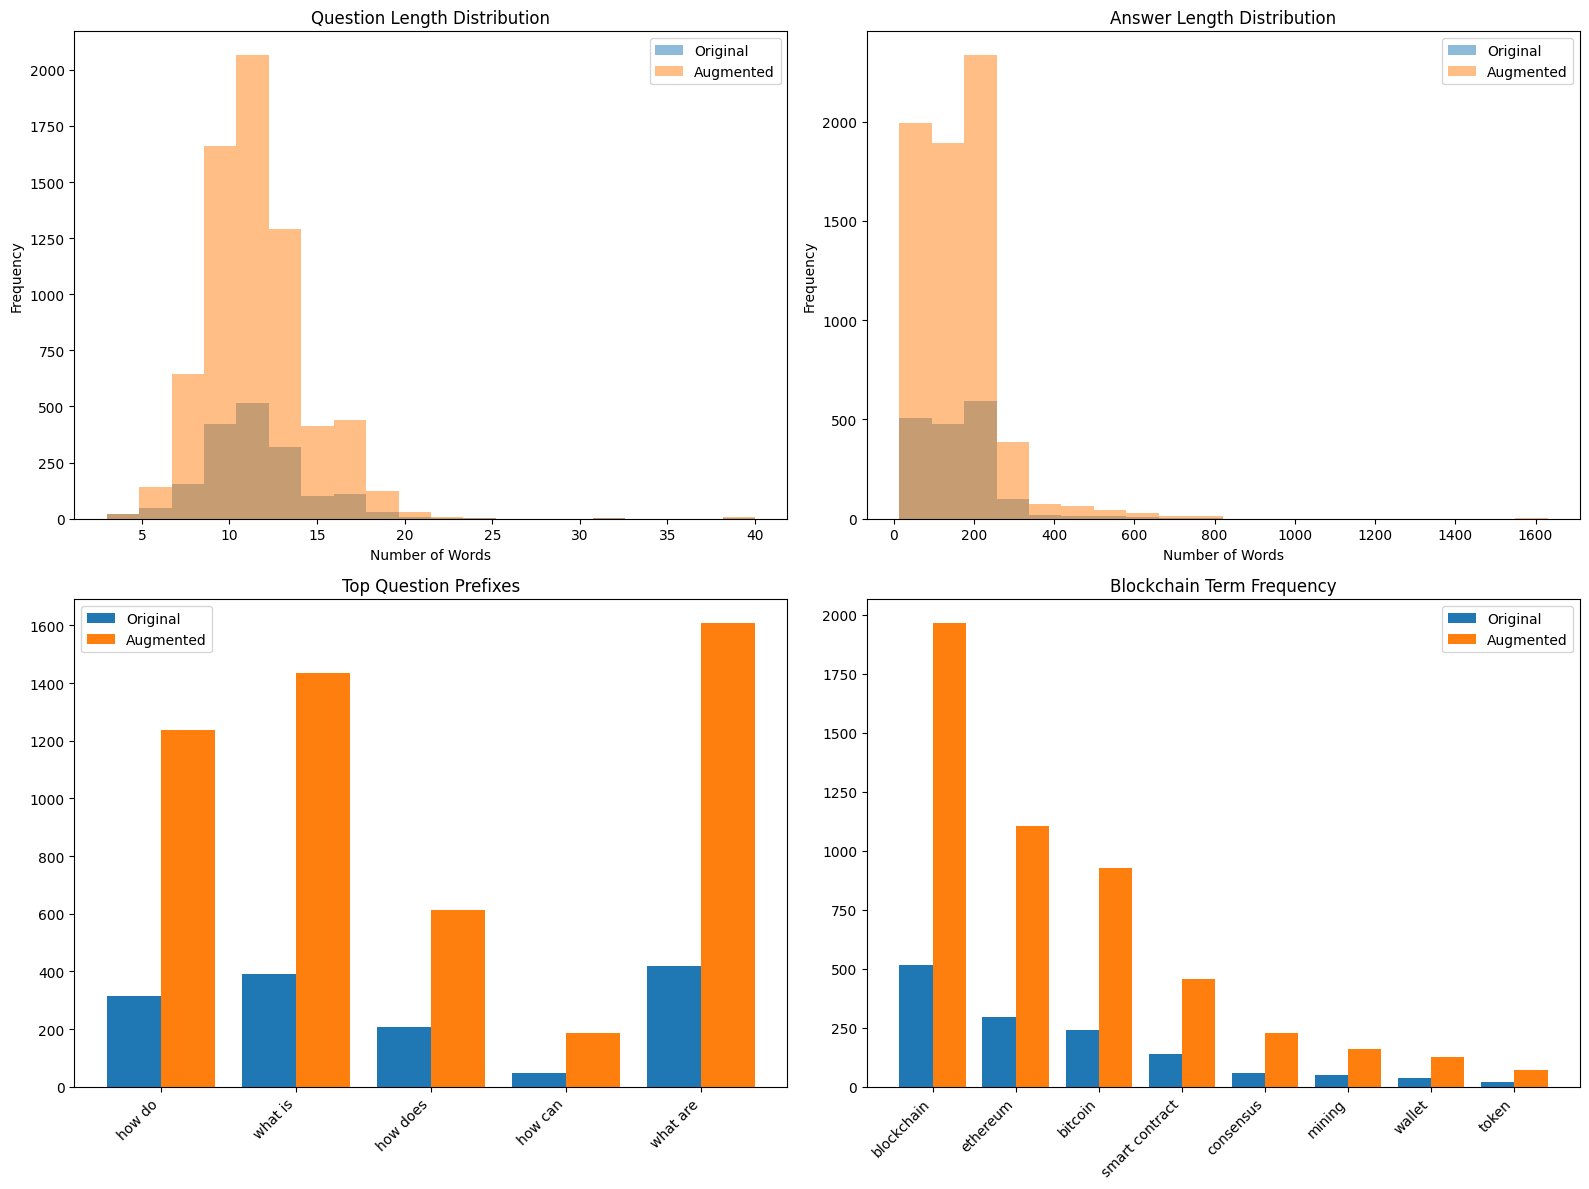


Augmented dataset saved to ./Block-Query/dataset/df_augmented.csv

AUGMENTATION EXAMPLES

Original Question: 'what are vanity addresses and how are they generated?'
Original Answer: 'vanity addresses are custom bitcoin addresses that contain specific characters or words chosen by the creator. for example, an address starting with '1coffee'. they are generated through a trial-and-error process:
1. generate random private key
2. derive public key
3. create bitcoin address
4. check if it matches desired pattern
5. if no match, repeat from step 1
the difficulty increases exponentially with the length of the desired pattern. each character adds a factor of 58 more attempts needed. while vanity addresses are cosmetic, they must still maintain all cryptographic properties of regular addresses.'

Augmented Questions:
1. 'what are conceit addresses and how are they generated?'
2. 'what are vanity handle and how are they generated?'
--------------------------------------------------

Original Q

In [8]:
def analyze_dataset(df, title):
    print(f"\n{'='*50}")
    print(f"{title} - Dataset Analysis")
    print(f"{'='*50}")
    print(f"Total number of samples: {len(df)}")

    # Question length analysis
    question_lengths = df['question'].apply(lambda x: len(x.split()))
    answer_lengths = df['answer'].apply(lambda x: len(x.split()))

    print("\nQuestion Length Statistics:")
    print(f"Mean: {question_lengths.mean():.2f} words")
    print(f"Median: {question_lengths.median()} words")
    print(f"Min: {question_lengths.min()} words")
    print(f"Max: {question_lengths.max()} words")

    print("\nAnswer Length Statistics:")
    print(f"Mean: {answer_lengths.mean():.2f} words")
    print(f"Median: {answer_lengths.median()} words")
    print(f"Min: {answer_lengths.min()} words")
    print(f"Max: {answer_lengths.max()} words")

    # Question prefix analysis
    def get_prefix(text, n_words=2):
        words = text.lower().strip().split()
        if len(words) >= n_words:
            return ' '.join(words[:n_words])
        return None

    prefixes = df['question'].apply(lambda x: get_prefix(x))
    top_prefixes = prefixes.value_counts().head(10)

    print("\nTop 10 Question Prefixes:")
    for prefix, count in top_prefixes.items():
        print(f"'{prefix}': {count} occurrences ({count/len(df)*100:.2f}%)")

    # Blockchain term frequency
    blockchain_terms = [
        "blockchain", "bitcoin", "ethereum", "smart contract", "defi",
        "nft", "mining", "wallet", "token", "consensus",
        "proof of stake", "proof of work"
    ]

    term_counts = {term: 0 for term in blockchain_terms}
    for question in df['question']:
        for term in blockchain_terms:
            if term in question.lower():
                term_counts[term] += 1

    print("\nBlockchain Term Frequency:")
    for term, count in sorted(term_counts.items(), key=lambda x: x[1], reverse=True):
        if count > 0:
            print(f"'{term}': {count} occurrences ({count/len(df)*100:.2f}%)")

    return {
        'question_lengths': question_lengths,
        'answer_lengths': answer_lengths,
        'top_prefixes': top_prefixes,
        'term_counts': term_counts
    }

def plot_dataset_comparison(original_stats, augmented_stats):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Question length distribution
    axes[0, 0].hist(original_stats['question_lengths'], bins=20, alpha=0.5, label='Original')
    axes[0, 0].hist(augmented_stats['question_lengths'], bins=20, alpha=0.5, label='Augmented')
    axes[0, 0].set_title('Question Length Distribution')
    axes[0, 0].set_xlabel('Number of Words')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()

    # Answer length distribution
    axes[0, 1].hist(original_stats['answer_lengths'], bins=20, alpha=0.5, label='Original')
    axes[0, 1].hist(augmented_stats['answer_lengths'], bins=20, alpha=0.5, label='Augmented')
    axes[0, 1].set_title('Answer Length Distribution')
    axes[0, 1].set_xlabel('Number of Words')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()

    # Top prefixes comparison
    orig_prefixes = original_stats['top_prefixes'].head(5)
    aug_prefixes = augmented_stats['top_prefixes'].head(5)

    prefix_labels = list(set(orig_prefixes.index) | set(aug_prefixes.index))[:8]
    orig_values = [orig_prefixes.get(label, 0) for label in prefix_labels]
    aug_values = [aug_prefixes.get(label, 0) for label in prefix_labels]

    x = range(len(prefix_labels))
    axes[1, 0].bar([i-0.2 for i in x], orig_values, width=0.4, label='Original')
    axes[1, 0].bar([i+0.2 for i in x], aug_values, width=0.4, label='Augmented')
    axes[1, 0].set_title('Top Question Prefixes')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(prefix_labels, rotation=45, ha='right')
    axes[1, 0].legend()

    # Blockchain term frequency comparison
    orig_terms = original_stats['term_counts']
    aug_terms = augmented_stats['term_counts']

    # Get top terms by frequency
    top_terms = sorted(orig_terms.items(), key=lambda x: x[1], reverse=True)[:8]
    term_labels = [t[0] for t in top_terms]

    orig_term_values = [orig_terms.get(label, 0) for label in term_labels]
    aug_term_values = [aug_terms.get(label, 0) for label in term_labels]

    x = range(len(term_labels))
    axes[1, 1].bar([i-0.2 for i in x], orig_term_values, width=0.4, label='Original')
    axes[1, 1].bar([i+0.2 for i in x], aug_term_values, width=0.4, label='Augmented')
    axes[1, 1].set_title('Blockchain Term Frequency')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(term_labels, rotation=45, ha='right')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig("dataset_comparison.png")
    plt.show()

def main():
    # Define paths
    DATA_PATH = "./Block-Query/dataset"

    # Load the original data
    print("Loading original dataset...")
    df_original = load_data(DATA_PATH)
    print(f"Original dataset loaded: {len(df_original)} QA pairs")

    # Clean the original data for analysis
    df_original["question"] = df_original["question"].apply(lambda x: x.lower().strip())
    df_original["answer"] = df_original["answer"].apply(lambda x: x.lower().strip())

    # Analyze original dataset
    original_stats = analyze_dataset(df_original, "ORIGINAL DATASET")

    # Apply augmentation
    print("\nApplying selective augmentation...")
    augmented_data = []

    # Set augmentation factor
    augmentation_factor = 3

    for _, row in df_original.iterrows():
        pairs = selective_augment_data(row['question'], row['answer'], augmentation_factor=augmentation_factor)
        augmented_data.extend(pairs)

    df_augmented = pd.DataFrame(augmented_data, columns=['question', 'answer'])
    print(f"Augmented dataset created: {len(df_augmented)} QA pairs")
    print(f"Expansion ratio: {len(df_augmented)/len(df_original):.2f}x")

    # Analyze augmented dataset
    augmented_stats = analyze_dataset(df_augmented, "AUGMENTED DATASET")

    # Plot comparison
    print("\nGenerating comparison plots...")
    plot_dataset_comparison(original_stats, augmented_stats)

    # Save the augmented dataset
    df_augmented.to_csv(os.path.join(DATA_PATH, "df_augmented.csv"), index=False)
    print(f"\nAugmented dataset saved to {os.path.join(DATA_PATH, 'df_augmented.csv')}")

    # Display a few examples of augmentation
    print("\n" + "="*50)
    print("AUGMENTATION EXAMPLES")
    print("="*50)

    original_questions = df_original['question'].sample(3).tolist()

    for question in original_questions:
        original_answer = df_original[df_original['question'] == question]['answer'].values[0]
        augmented_pairs = selective_augment_data(question, original_answer, augmentation_factor=augmentation_factor)

        print(f"\nOriginal Question: '{question}'")
        print(f"Original Answer: '{original_answer}'")
        print("\nAugmented Questions:")

        for i, (aug_q, _) in enumerate(augmented_pairs[1:], 1):  # Skip the first one as it's the original
            print(f"{i}. '{aug_q}'")
        print("-" * 50)

if __name__ == "__main__":
    main()

## Model Building

In [9]:
def build_pegasus_model(model_name="google/pegasus-large", dropout_rate=0.1):
    config = PegasusConfig.from_pretrained(model_name, dropout=dropout_rate)

    if hasattr(config, "max_length"):
        delattr(config, "max_length")
    if hasattr(config, "num_beams"):
        delattr(config, "num_beams")
    if hasattr(config, "length_penalty"):
        delattr(config, "length_penalty")

    model = TFPegasusForConditionalGeneration.from_pretrained(model_name, config=config)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        clipnorm=1.0,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )

    model.compile(optimizer=optimizer)
    return model

## Evaluation functions

In [22]:
def ask_question(question, model, tokenizer, generation_config, max_length=150):
    input_text = question.lower().strip()

    inputs = tokenizer(
        input_text,
        return_tensors="tf",
        padding=True,
        truncation=True,
        max_length=MAX_SOURCE_LENGTH
    )

    if max_length is not None:
        generation_config.max_length = max_length

    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        generation_config=generation_config
    )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

In [12]:
def evaluate_model(model, tokenizer, test_df, generation_config, num_samples=5, max_length=150):
    rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
    smooth = SmoothingFunction().method1

    if len(test_df) > num_samples:
        test_sample = test_df.sample(num_samples, random_state=42)
    else:
        test_sample = test_df

    references = []
    hypotheses = []

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    bleu1_scores = []
    bleu2_scores = []
    bleu3_scores = []
    similarity_percentages = []

    for _, row in test_sample.iterrows():
        question = row['question']
        reference = row['answer']

        # Generate answer
        generated = ask_question(question, model, tokenizer, generation_config)

        # Process for BLEU
        reference_tokens = reference.split()
        generated_tokens = generated.split()

        references.append([reference_tokens])
        hypotheses.append(generated_tokens)

        # ROUGE scores
        rouge_scores = rouge_scorer_instance.score(reference, generated)
        rouge1 = rouge_scores['rouge1'].fmeasure
        rouge2 = rouge_scores['rouge2'].fmeasure
        rougeL = rouge_scores['rougeL'].fmeasure

        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)

        # Individual BLEU scores
        bleu1 = sentence_bleu([reference_tokens], generated_tokens,
                          weights=(1, 0, 0, 0),
                          smoothing_function=smooth)
        bleu2 = sentence_bleu([reference_tokens], generated_tokens,
                          weights=(0.5, 0.5, 0, 0),
                          smoothing_function=smooth)
        bleu3 = sentence_bleu([reference_tokens], generated_tokens,
                          weights=(0.33, 0.33, 0.33, 0),
                          smoothing_function=smooth)

        bleu1_scores.append(bleu1)
        bleu2_scores.append(bleu2)
        bleu3_scores.append(bleu3)

        similarity_percentage = rougeL * 100
        similarity_percentages.append(similarity_percentage)

    results = {
        'bleu1_avg': sum(bleu1_scores) / len(bleu1_scores),
        'bleu2_avg': sum(bleu2_scores) / len(bleu2_scores),
        'bleu3_avg': sum(bleu3_scores) / len(bleu3_scores),
        'rouge1': sum(rouge1_scores) / len(rouge1_scores),
        'rouge2': sum(rouge2_scores) / len(rouge2_scores),
        'rougeL': sum(rougeL_scores) / len(rougeL_scores),
        'similarity_percentage': sum(similarity_percentages) / len(similarity_percentages),
    }

    # Print the overall metrics
    print("\n" + "="*50)
    print("EVALUATION METRICS")
    print("="*50)
    print(f"BLEU-1: {results['bleu1_avg']:.4f}")
    print(f"BLEU-2: {results['bleu2_avg']:.4f}")
    print(f"BLEU-3: {results['bleu3_avg']:.4f}")
    print(f"ROUGE-1: {results['rouge1']:.4f}")
    print(f"ROUGE-2: {results['rouge2']:.4f}")
    print(f"ROUGE-L: {results['rougeL']:.4f}")
    print(f"Similarity Percentage: {results['similarity_percentage']:.2f}%")

    return results

def evaluate_model_detailed(model, tokenizer, test_df, generation_config, num_samples=5, max_length=150):
    rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
    smooth = SmoothingFunction().method1

    if len(test_df) > num_samples:
        test_sample = test_df.sample(num_samples, random_state=42)
    else:
        test_sample = test_df

    references = []
    hypotheses = []

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    bleu1_scores = []
    bleu2_scores = []
    bleu3_scores = []
    similarity_percentages = []

    # Store detailed results for all samples
    detailed_results = []

    print("\n" + "="*80)
    print("DETAILED EVALUATION RESULTS".center(80))
    print("="*80)

    for idx, (_, row) in enumerate(test_sample.iterrows(), 1):
        question = row['question']
        reference = row['answer']

        # Generate answer
        generated = ask_question(question, model, tokenizer, generation_config)

        # Process for BLEU
        reference_tokens = reference.split()
        generated_tokens = generated.split()

        references.append([reference_tokens])
        hypotheses.append(generated_tokens)

        # ROUGE scores
        rouge_scores = rouge_scorer_instance.score(reference, generated)
        rouge1 = rouge_scores['rouge1'].fmeasure
        rouge2 = rouge_scores['rouge2'].fmeasure
        rougeL = rouge_scores['rougeL'].fmeasure

        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)

        # Individual BLEU scores
        bleu1 = sentence_bleu([reference_tokens], generated_tokens,
                          weights=(1, 0, 0, 0),
                          smoothing_function=smooth)
        bleu2 = sentence_bleu([reference_tokens], generated_tokens,
                          weights=(0.5, 0.5, 0, 0),
                          smoothing_function=smooth)
        bleu3 = sentence_bleu([reference_tokens], generated_tokens,
                          weights=(0.33, 0.33, 0.33, 0),
                          smoothing_function=smooth)

        bleu1_scores.append(bleu1)
        bleu2_scores.append(bleu2)
        bleu3_scores.append(bleu3)

        # Calculate similarity percentage (based on ROUGE-L which captures longest common subsequence)
        similarity_percentage = rougeL * 100
        similarity_percentages.append(similarity_percentage)

        # Store detailed results for this sample
        result = {
            'question': question,
            'reference': reference,
            'generated': generated,
            'rouge1': rouge1,
            'rouge2': rouge2,
            'rougeL': rougeL,
            'bleu1': bleu1,
            'bleu2': bleu2,
            'bleu3': bleu3,
            'similarity_percentage': similarity_percentage
        }

        detailed_results.append(result)

        # Print detailed results for each sample
        print(f"\nSample #{idx}:")
        print("-" * 80)
        print(f"Question: {question}")
        print(f"\nReference Answer: {reference}")
        print(f"\nGenerated Answer: {generated}")
        print("\nMetrics:")
        print(f"  ROUGE-1: {rouge1:.4f}")
        print(f"  ROUGE-2: {rouge2:.4f}")
        print(f"  ROUGE-L: {rougeL:.4f}")
        print(f"  BLEU-1:  {bleu1:.4f}")
        print(f"  BLEU-2:  {bleu2:.4f}")
        print(f"  BLEU-3:  {bleu3:.4f}")
        print(f"  Similarity: {similarity_percentage:.2f}%")
        print("-" * 80)

    # Calculate and print average metrics
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
    avg_bleu1 = sum(bleu1_scores) / len(bleu1_scores)
    avg_bleu2 = sum(bleu2_scores) / len(bleu2_scores)
    avg_bleu3 = sum(bleu3_scores) / len(bleu3_scores)
    avg_similarity = sum(similarity_percentages) / len(similarity_percentages)

    print("\n" + "="*80)
    print("AVERAGE METRICS ACROSS ALL SAMPLES".center(80))
    print("="*80)
    print(f"Average ROUGE-1: {avg_rouge1:.4f}")
    print(f"Average ROUGE-2: {avg_rouge2:.4f}")
    print(f"Average ROUGE-L: {avg_rougeL:.4f}")
    print(f"Average BLEU-1:  {avg_bleu1:.4f}")
    print(f"Average BLEU-2:  {avg_bleu2:.4f}")
    print(f"Average BLEU-3:  {avg_bleu3:.4f}")
    print(f"Average Similarity: {avg_similarity:.2f}%")
    print("="*80)

    return detailed_results

In [19]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Loss plot
    axes[0].plot(history['loss'], label='Training Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Learning rate plot
    if 'learning_rate' in history and history['learning_rate']:
        axes[1].plot(history['learning_rate'], label='Learning Rate')
        axes[1].set_title('Learning Rate')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Learning Rate')
        axes[1].set_yscale('log')

    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "Pegasus_training_history.png"))
    plt.show()

## Pipeline functions

In [13]:
def cleanup_model_config(model):
    if hasattr(model.config, "max_length"):
        delattr(model.config, "max_length")
    if hasattr(model.config, "num_beams"):
        delattr(model.config, "num_beams")
    if hasattr(model.config, "length_penalty"):
        delattr(model.config, "length_penalty")
    return model

def train_in_steps(
    model,
    tokenizer,
    train_inputs, train_labels,
    val_inputs, val_labels,
    total_epochs=TOTAL_EPOCHS,
    epochs_per_step=EPOCHS_PER_STEP,
    batch_size=BATCH_SIZE,
    save_dir=SAVE_DIR
):
    num_steps = total_epochs // epochs_per_step
    step_model_paths = [os.path.join(save_dir, f"pegasus_model_step_{i+1}") for i in range(num_steps)]
    history_path = os.path.join(save_dir, "pegasus_training_history.json")

    combined_history = {
        'loss': [], 'val_loss': [],
        'learning_rate': []
    }

    # Load existing history if available
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            saved_history = json.load(f)
            for key in combined_history:
                if key in saved_history:
                    combined_history[key] = saved_history[key]

    # Find the last completed step
    last_completed_step = -1
    for i in range(num_steps):
        if os.path.exists(os.path.join(step_model_paths[i], "config.json")):
            last_completed_step = i

    # Resume training from the last completed step
    if last_completed_step >= 0:
        print(f"Loading model from step {last_completed_step + 1}")
        config = PegasusConfig.from_pretrained(step_model_paths[last_completed_step])
        model = TFPegasusForConditionalGeneration.from_pretrained(step_model_paths[last_completed_step])
        model = cleanup_model_config(model)

        optimizer = tf.keras.optimizers.Adam(
            learning_rate=LEARNING_RATE,
            clipnorm=1.0,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7
        )

        model.compile(optimizer=optimizer)
        print("Model recompiled after loading from checkpoint")

        next_step = last_completed_step + 1
    else:
        next_step = 0

    current_epoch = next_step * epochs_per_step

    # Training loop
    for step in range(next_step, num_steps):
        print(f"\n{'='*50}")
        print(f"Training Step {step + 1}/{num_steps} (Epochs {step*epochs_per_step + 1}-{(step+1)*epochs_per_step})")
        print(f"{'='*50}")

        step_callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True,
                min_delta=1e-4
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=2,
                min_lr=1e-6,
                verbose=1
            )
        ]

        epochs_this_step = min(epochs_per_step, total_epochs - current_epoch)

        train_dataset = tf.data.Dataset.from_tensor_slices((
            {"input_ids": train_inputs["input_ids"],
             "attention_mask": train_inputs["attention_mask"]},
            train_labels
        )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_dataset = tf.data.Dataset.from_tensor_slices((
            {"input_ids": val_inputs["input_ids"],
             "attention_mask": val_inputs["attention_mask"]},
            val_labels
        )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Training for this step
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs_this_step,
            callbacks=step_callbacks
        )

        model.save_pretrained(step_model_paths[step])
        tokenizer.save_pretrained(step_model_paths[step])
        print(f"Saved model for step {step + 1} at: {step_model_paths[step]}")

        for key in history.history:
            if key in combined_history:
                combined_history[key].extend(history.history[key])

        combined_history['learning_rate'].extend(
            [float(model.optimizer.learning_rate.numpy())] * len(history.history['loss'])
        )

        with open(history_path, 'w') as f:
            json.dump(combined_history, f)

        current_epoch += epochs_this_step

    print("Training complete! Saving final model...")
    final_model_path = os.path.join(save_dir, "pegasus_final_model")
    model.save_pretrained(final_model_path)
    tokenizer.save_pretrained(final_model_path)

    plot_training_history(combined_history)

    return model, combined_history

In [16]:
def pegasus_training_pipeline(data_path, save_dir=SAVE_DIR, model_size=MODEL_SIZE, apply_augmentation=True,
                         eval_batch_size=8):
    print(f"Starting PEGASUS training pipeline with {model_size} model")

    os.makedirs(save_dir, exist_ok=True)

    # 1. Load data (same as before)
    if os.path.exists(os.path.join(data_path, "df_augmented.csv")) and apply_augmentation:
        print("Loading pre-augmented dataset...")
        df = pd.read_csv(os.path.join(data_path, "df_augmented.csv"))
        apply_augmentation = False
    else:
        print("Loading original dataset...")
        df = load_data(data_path)

    print(f"Dataset size before splitting: {len(df)} QA pairs")

    # 2. Prepare data (same function can be used)
    df_train, df_val, df_test = prepare_data_for_pegasus(
        df,
        validation_split=0.2,
        test_split=0.1,
        apply_augmentation=apply_augmentation
    )

    # 3. Load PEGASUS tokenizer and model
    print(f"Loading {model_size} model and tokenizer...")
    generation_config = GenerationConfig(
        max_length=MAX_TARGET_LENGTH,
        num_beams=4,
        no_repeat_ngram_size=3,
        early_stopping=True
    )

    generation_config.save_pretrained(save_dir)
    tokenizer = PegasusTokenizer.from_pretrained(model_size)
    model = build_pegasus_model(model_name=model_size, dropout_rate=0.1)

    # 4. Process data with PEGASUS tokenizer
    print("Tokenizing data...")
    train_inputs, train_labels = preprocess_data_pegasus(
        df_train,
        tokenizer,
        max_source_length=MAX_SOURCE_LENGTH,
        max_target_length=MAX_TARGET_LENGTH
    )

    val_inputs, val_labels = preprocess_data_pegasus(
        df_val,
        tokenizer,
        max_source_length=MAX_SOURCE_LENGTH,
        max_target_length=MAX_TARGET_LENGTH
    )

    # 5. Train the model (same train_in_steps function can be used)
    print("Starting model training...")
    model, history = train_in_steps(
        model=model,
        tokenizer=tokenizer,
        train_inputs=train_inputs,
        train_labels=train_labels,
        val_inputs=val_inputs,
        val_labels=val_labels,
        total_epochs=TOTAL_EPOCHS,
        epochs_per_step=EPOCHS_PER_STEP,
        batch_size=BATCH_SIZE,
        save_dir=save_dir
    )

    # 6. Evaluate the model (same evaluation functions can be used)
    print("Evaluating model performance...")

    generation_config = GenerationConfig.from_pretrained(save_dir)

    eval_results = evaluate_model(
        model=model,
        tokenizer=tokenizer,
        test_df=df_test,
        generation_config=generation_config,
        num_samples=50,
        max_length=MAX_TARGET_LENGTH
    )

    detailed_results = evaluate_model_detailed(
        model=model,
        tokenizer=tokenizer,
        test_df=df_test,
        generation_config=generation_config,
        num_samples=5,
        max_length=MAX_TARGET_LENGTH
    )

    return model, tokenizer, eval_results

## Training and Results

Starting PEGASUS training pipeline with google/pegasus-xsum model
Loading pre-augmented dataset...
Dataset size before splitting: 6855 QA pairs
Skipping augmentation
Train set: 4798 samples
Validation set: 1371 samples
Test set: 686 samples
Loading google/pegasus-xsum model and tokenizer...


All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

Some layers of TFPegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing data...
Starting model training...
Loading model from step 4


All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

All the layers of TFPegasusForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/block-query/Pegasus/pegasus_model_step_4.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFPegasusForConditionalGeneration for predictions without further training.


Model recompiled after loading from checkpoint
Training complete! Saving final model...


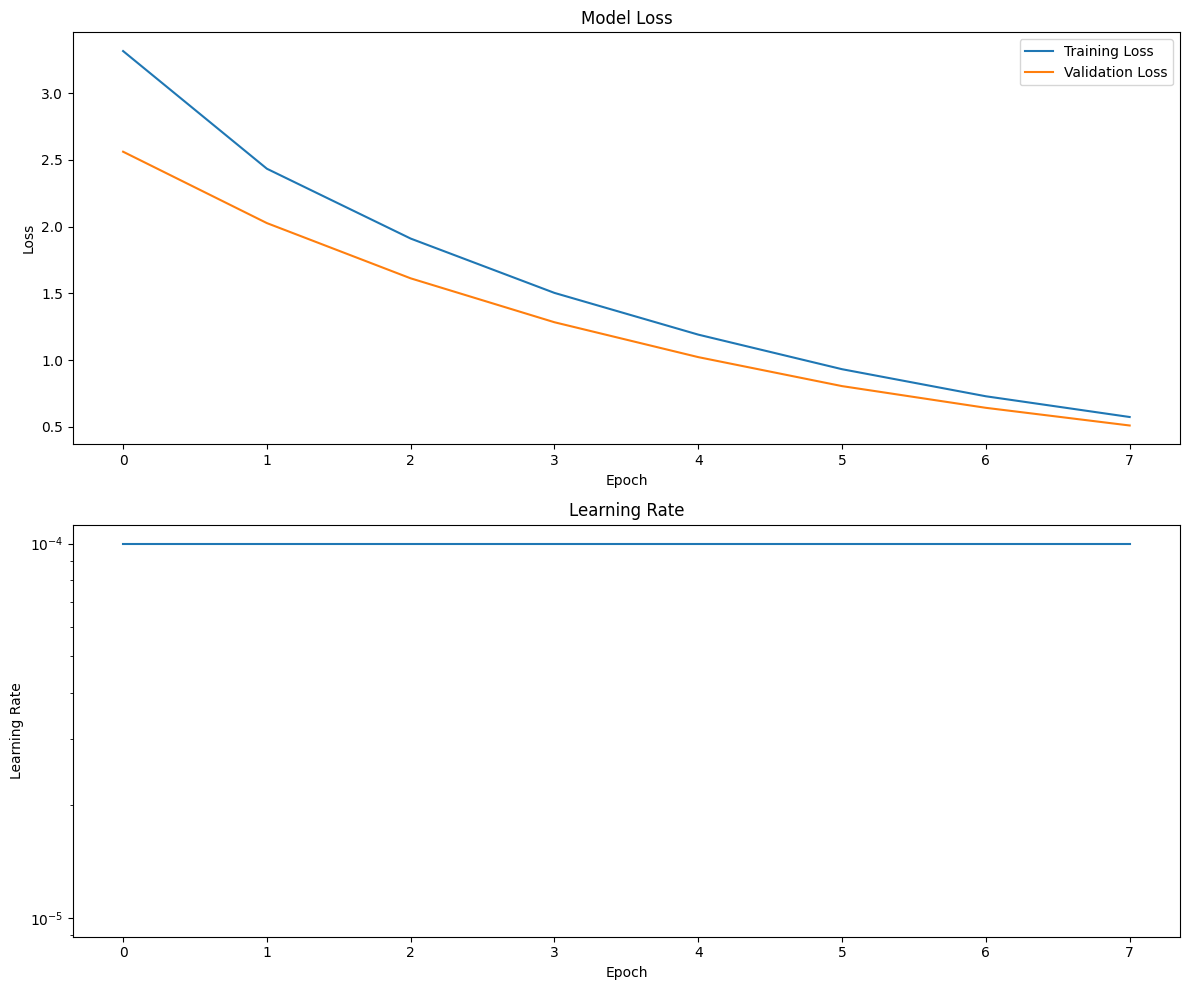

Evaluating model performance...

EVALUATION METRICS
BLEU-1: 0.4074
BLEU-2: 0.3439
BLEU-3: 0.3136
ROUGE-1: 0.5372
ROUGE-2: 0.3743
ROUGE-L: 0.4316
Similarity Percentage: 43.16%

                          DETAILED EVALUATION RESULTS                           

Sample #1:
--------------------------------------------------------------------------------
Question: how manage proof of burn create scarcity and value in cryptocurrency systems?

Reference Answer: proof of burn creates scarcity and value by requiring users to permanently destroy (burn) coins by sending them to an unspendable address. this mechanism:

1) reduces total supply, potentially increasing value
2) demonstrates long-term commitment to the network
3) provides an alternative to energy-intensive mining
4) creates virtual mining power proportional to burned coins

the burned coins are verifiably unrecoverable, and the act of burning gives users rights or privileges within the network, similar to staking.

Generated Answer: pro

In [ ]:
model, tokenizer, eval_results = pegasus_training_pipeline(
    data_path=DATA_PATH,
    save_dir=SAVE_DIR,
    model_size=MODEL_SIZE,
    apply_augmentation=True
)

## Seperate evaluation (incase evaluation was incomplete or any error in the pipeline)

In [ ]:
step_to_load = 4
model_path = os.path.join(SAVE_DIR, f"pegasus_model_step_{step_to_load}")
tokenizer = PegasusTokenizer.from_pretrained(model_path)
model = TFPegasusForConditionalGeneration.from_pretrained(model_path)
generation_config = GenerationConfig.from_pretrained(save_dir)

if os.path.exists(os.path.join(DATA_PATH, "df_augmented.csv")):
  print("Loading pre-augmented dataset...")
  df = pd.read_csv(os.path.join(DATA_PATH, "df_augmented.csv"))
  apply_augmentation = False
else:
  print("Loading original dataset...")
  df = load_data(DATA_PATH)

  print(f"Dataset size before splitting: {len(df)} QA pairs")

df_train, df_val, df_test = prepare_data_for_pegasus(
    df,
    validation_split=0.2,
    test_split=0.1,
    apply_augmentation=apply_augmentation
)

eval_results = evaluate_model(
    model=model,
    tokenizer=tokenizer,
    test_df=df_test,
    num_samples=100,
    max_length=MAX_TARGET_LENGTH,
    generation_config
)

detailed_results = evaluate_model_detailed(
    model=model,
    tokenizer=tokenizer,
    test_df=df_test,
    num_samples=5,
    max_length=MAX_TARGET_LENGTH,
    generation_config
)